In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#!kaggle datasets list

In [6]:
!kaggle competitions download -c santander-product-recommendation

100% 228M/228M [00:13<00:00, 16.8MB/s]
100% 228M/228M [00:13<00:00, 18.1MB/s]


In [7]:
!mkdir santander-product-recommendation

In [8]:
!unzip santander-product-recommendation.zip -d train

Archive:  santander-product-recommendation.zip
  inflating: train/sample_submission.csv.zip  
  inflating: train/test_ver2.csv.zip  
  inflating: train/train_ver2.csv.zip  


In [9]:
!unzip train/sample_submission.csv.zip -d train

Archive:  train/sample_submission.csv.zip
  inflating: train/sample_submission.csv  


In [10]:
!unzip train/test_ver2.csv.zip -d train

Archive:  train/test_ver2.csv.zip
  inflating: train/test_ver2.csv     


In [11]:
!unzip train/train_ver2.csv.zip -d train

Archive:  train/train_ver2.csv.zip
  inflating: train/train_ver2.csv    


In [12]:
!ls

kaggle.json  santander-product-recommendation	   train
sample_data  santander-product-recommendation.zip


In [13]:
## Rows and Columns

In [14]:
df = pd.read_csv('/content/train/train_ver2.csv', nrows=500000)


# Display the first few rows of the dataframe
print(df.head())

<ipython-input-14-6a481a7af399>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/train/train_ver2.csv', nrows=500000)


   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-01-28   1375586            N              ES    H   35  2015-01-12   
1  2015-01-28   1050611            N              ES    V   23  2012-08-10   
2  2015-01-28   1050612            N              ES    V   23  2012-08-10   
3  2015-01-28   1050613            N              ES    H   22  2012-08-10   
4  2015-01-28   1050614            N              ES    V   23  2012-08-10   

   ind_nuevo antiguedad  indrel  ... ind_hip_fin_ult1  ind_plan_fin_ult1  \
0        0.0          6     1.0  ...                0                  0   
1        0.0         35     1.0  ...                0                  0   
2        0.0         35     1.0  ...                0                  0   
3        0.0         35     1.0  ...                0                  0   
4        0.0         35     1.0  ...                0                  0   

  ind_pres_fin_ult1 ind_reca_fin_ult1 ind_tjcr_fin_ult1 ind_valo_fin_ult1 

In [15]:
### missing values

In [16]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({'Column': missing_percentage.index, 'Missing Percentage': missing_percentage.values})

missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)

print(missing_df)


                   Column  Missing Percentage
15               conyuemp             99.9822
10         ult_fec_cli_1t             99.8680
22                  renta             17.7802
19               cod_prov              1.5590
20                nomprov              1.5590
23               segmento              1.0886
16          canal_entrada              1.0858
4                    sexo              1.0780
13                indresi              1.0778
12            tiprel_1mes              1.0778
14                 indext              1.0778
3         pais_residencia              1.0778
7               ind_nuevo              1.0778
11            indrel_1mes              1.0778
6              fecha_alta              1.0778
2            ind_empleado              1.0778
9                  indrel              1.0778
17                indfall              1.0778
18                tipodom              1.0778
21  ind_actividad_cliente              1.0778
46      ind_nom_pens_ult1         

Most likely drop the first 2 columns because they have more missing values than any at all.

In [17]:
## df1 aka dropping the nan columns...

columns_to_drop = ['conyuemp', 'ult_fec_cli_1t']
df1 = df.drop(columns=columns_to_drop)

print(df1.head())


   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-01-28   1375586            N              ES    H   35  2015-01-12   
1  2015-01-28   1050611            N              ES    V   23  2012-08-10   
2  2015-01-28   1050612            N              ES    V   23  2012-08-10   
3  2015-01-28   1050613            N              ES    H   22  2012-08-10   
4  2015-01-28   1050614            N              ES    V   23  2012-08-10   

   ind_nuevo antiguedad  indrel  ...  ind_hip_fin_ult1 ind_plan_fin_ult1  \
0        0.0          6     1.0  ...                 0                 0   
1        0.0         35     1.0  ...                 0                 0   
2        0.0         35     1.0  ...                 0                 0   
3        0.0         35     1.0  ...                 0                 0   
4        0.0         35     1.0  ...                 0                 0   

  ind_pres_fin_ult1 ind_reca_fin_ult1 ind_tjcr_fin_ult1 ind_valo_fin_ult1 

Dropped also the unnessary columns like the ID and province since we have other columns that are specific, like rent can tell more about the cost of living more. There's also columns stating whether they are foreign or not and their primary address.

In [18]:
num_features = len(df1.columns)

numerical_features = []
categorical_features = []

for column in df1.columns:
    if df1[column].dtype == 'object':
        categorical_features.append(column)
    else:
        numerical_features.append(column)

print(f"Number of features: {num_features}")
print("\nNumerical Features:")
print(numerical_features)
print("\nCategorical Features:")
print(categorical_features)


Number of features: 46

Numerical Features:
['ncodpers', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente', 'renta', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

Categorical Features:
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'age', 'fecha_alta', 'antiguedad', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


The age (Age) and antiguedad (Customer seniority in months) are numerical based on the description but they were counted as categorical... I feel like it is important so I am going to keep it

In [19]:
# Correct categorization for 'age' and 'antiguedad' features

if 'age' in categorical_features:
    categorical_features.remove('age')
    numerical_features.append('age')
if 'antiguedad' in categorical_features:
    categorical_features.remove('antiguedad')
    numerical_features.append('antiguedad')

print(f"Number of features: {num_features}")
print("\nNumerical Features:")
print(numerical_features)
print("\nCategorical Features:")
print(categorical_features)

Number of features: 46

Numerical Features:
['ncodpers', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente', 'renta', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1', 'age', 'antiguedad']

Categorical Features:
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [20]:
numerical_df1 = df1[numerical_features]
print(numerical_df1.head())

   ncodpers  ind_nuevo  indrel  indrel_1mes  tipodom  cod_prov  \
0   1375586        0.0     1.0          1.0      1.0      29.0   
1   1050611        0.0     1.0          1.0      1.0      13.0   
2   1050612        0.0     1.0          1.0      1.0      13.0   
3   1050613        0.0     1.0          1.0      1.0      50.0   
4   1050614        0.0     1.0          1.0      1.0      50.0   

   ind_actividad_cliente      renta  ind_ahor_fin_ult1  ind_aval_fin_ult1  \
0                    1.0   87218.10                  0                  0   
1                    0.0   35548.74                  0                  0   
2                    0.0  122179.11                  0                  0   
3                    0.0  119775.54                  0                  0   
4                    1.0        NaN                  0                  0   

   ...  ind_pres_fin_ult1  ind_reca_fin_ult1  ind_tjcr_fin_ult1  \
0  ...                  0                  0                  0   
1  ...

In [21]:
## checking smallest and largest value of each column

feature_min_max = numerical_df1.agg(['min', 'max'])

print("Smallest and Largest Values of Numerical Features:\n")

print(feature_min_max)

Smallest and Largest Values of Numerical Features:

     ncodpers  ind_nuevo  indrel  indrel_1mes  tipodom  cod_prov  \
min     15889        0.0     1.0          1.0      1.0       1.0   
max   1379131        1.0    99.0          3.0      1.0      52.0   

     ind_actividad_cliente        renta  ind_ahor_fin_ult1  ind_aval_fin_ult1  \
min                    0.0      1202.73                  0                  0   
max                    1.0  28894395.51                  1                  1   

     ...  ind_pres_fin_ult1  ind_reca_fin_ult1  ind_tjcr_fin_ult1  \
min  ...                  0                  0                  0   
max  ...                  1                  1                  1   

     ind_valo_fin_ult1  ind_viv_fin_ult1  ind_nomina_ult1  ind_nom_pens_ult1  \
min                  0                 0              0.0                0.0   
max                  1                 1              1.0                1.0   

     ind_recibo_ult1  age  antiguedad  
min       

Everything has a reasonable range based on the description but the antiguedad aka Customer seniority (in months), the min is -999999.0

I'm gonna change all the negative to zero in this column...

In [22]:
df1['antiguedad'] = pd.to_numeric(df1['antiguedad'], errors='coerce')

df1['antiguedad'] = df1['antiguedad'].apply(lambda x: max(0, x))

print(df1['antiguedad'])

0           6.0
1          35.0
2          35.0
3          35.0
4          35.0
          ...  
499995    103.0
499996    103.0
499997    103.0
499998    103.0
499999     76.0
Name: antiguedad, Length: 500000, dtype: float64


In [23]:
print("Minimum value of 'antiguedad':", df1['antiguedad'].min())
print("Maximum value of 'antiguedad':", df1['antiguedad'].max())

Minimum value of 'antiguedad': 0.0
Maximum value of 'antiguedad': 246.0


In [24]:
categorical_df1= df1[categorical_features]
print(categorical_df1.head())

   fecha_dato ind_empleado pais_residencia sexo  fecha_alta tiprel_1mes  \
0  2015-01-28            N              ES    H  2015-01-12           A   
1  2015-01-28            N              ES    V  2012-08-10           I   
2  2015-01-28            N              ES    V  2012-08-10           I   
3  2015-01-28            N              ES    H  2012-08-10           I   
4  2015-01-28            N              ES    V  2012-08-10           A   

  indresi indext canal_entrada indfall      nomprov            segmento  
0       S      N           KHL       N       MALAGA   02 - PARTICULARES  
1       S      S           KHE       N  CIUDAD REAL  03 - UNIVERSITARIO  
2       S      N           KHE       N  CIUDAD REAL  03 - UNIVERSITARIO  
3       S      N           KHD       N     ZARAGOZA  03 - UNIVERSITARIO  
4       S      N           KHE       N     ZARAGOZA  03 - UNIVERSITARIO  


In [25]:
print(df1.head())


   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-01-28   1375586            N              ES    H   35  2015-01-12   
1  2015-01-28   1050611            N              ES    V   23  2012-08-10   
2  2015-01-28   1050612            N              ES    V   23  2012-08-10   
3  2015-01-28   1050613            N              ES    H   22  2012-08-10   
4  2015-01-28   1050614            N              ES    V   23  2012-08-10   

   ind_nuevo  antiguedad  indrel  ...  ind_hip_fin_ult1 ind_plan_fin_ult1  \
0        0.0         6.0     1.0  ...                 0                 0   
1        0.0        35.0     1.0  ...                 0                 0   
2        0.0        35.0     1.0  ...                 0                 0   
3        0.0        35.0     1.0  ...                 0                 0   
4        0.0        35.0     1.0  ...                 0                 0   

  ind_pres_fin_ult1 ind_reca_fin_ult1 ind_tjcr_fin_ult1 ind_valo_fin

In [26]:
print("Updated Categorical Features:")
print(categorical_features)

Updated Categorical Features:
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [27]:
import seaborn as sns

# Summary statistics
print(df1[numerical_features].describe())

           ncodpers      ind_nuevo         indrel    indrel_1mes   tipodom  \
count  5.000000e+05  494611.000000  494611.000000  494611.000000  494611.0   
mean   8.171304e+05       0.000303       1.130769       1.000091       1.0   
std    4.381616e+05       0.017412       3.577475       0.013414       0.0   
min    1.588900e+04       0.000000       1.000000       1.000000       1.0   
25%    3.362618e+05       0.000000       1.000000       1.000000       1.0   
50%    9.856585e+05       0.000000       1.000000       1.000000       1.0   
75%    1.177883e+06       0.000000       1.000000       1.000000       1.0   
max    1.379131e+06       1.000000      99.000000       3.000000       1.0   

            cod_prov  ind_actividad_cliente         renta  ind_ahor_fin_ult1  \
count  492205.000000          494611.000000  4.110990e+05      500000.000000   
mean       26.395049               0.519503  1.318600e+05           0.000128   
std        12.844092               0.499620  2.293840e+05

In [28]:
## Missing values and Outliers

In [29]:
missing_values_count = df1.isnull().sum()
missing_values_count_sorted = missing_values_count.sort_values(ascending=False)

outliers = df1.describe().transpose()

print("Missing Values Count (Sorted):")
print(missing_values_count_sorted)

print("\nPotential Outliers:")
print(outliers)


Missing Values Count (Sorted):
renta                    88901
cod_prov                  7795
nomprov                   7795
segmento                  5443
canal_entrada             5429
sexo                      5390
indresi                   5389
tiprel_1mes               5389
indext                    5389
ind_empleado              5389
pais_residencia           5389
indrel                    5389
ind_nuevo                 5389
fecha_alta                5389
indrel_1mes               5389
indfall                   5389
tipodom                   5389
ind_actividad_cliente     5389
ind_nom_pens_ult1         2266
ind_nomina_ult1           2266
ncodpers                     0
age                          0
antiguedad                   0
fecha_dato                   0
ind_ahor_fin_ult1            0
ind_aval_fin_ult1            0
ind_cno_fin_ult1             0
ind_ctju_fin_ult1            0
ind_cco_fin_ult1             0
ind_cder_fin_ult1            0
ind_ctop_fin_ult1            0
ind_ctma

Interesting to see how the columns that contain missing values have the same number of missing values...

In [30]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Concatenate the one-hot encoded target columns
target_columns = df1.columns[df1.columns.str.startswith('ind_')].tolist()
target_df1 = df1[target_columns]

# Convert one-hot encoded vectors to label encodings
for column in target_df1.columns:
    target_df1.loc[:, column] = label_encoder.fit_transform(target_df1[column])

# Sum the encoded values across columns to represent the new column
target_df1['checked_services'] = target_df1.sum(axis=1)

# Create user-item interaction matrix without 'ncodpers' column
user_item_matrix = target_df1.copy()

# Display the user-item interaction matrix
print("User-Item Interaction Matrix:")
print(user_item_matrix.head())


User-Item Interaction Matrix:
  ind_empleado  ind_nuevo  ind_actividad_cliente  ind_ahor_fin_ult1  \
0            3        0.0                    1.0                  0   
1            3        0.0                    0.0                  0   
2            3        0.0                    0.0                  0   
3            3        0.0                    0.0                  0   
4            3        0.0                    1.0                  0   

   ind_aval_fin_ult1  ind_cco_fin_ult1  ind_cder_fin_ult1  ind_cno_fin_ult1  \
0                  0                 1                  0                 0   
1                  0                 1                  0                 0   
2                  0                 1                  0                 0   
3                  0                 0                  0                 0   
4                  0                 1                  0                 0   

   ind_ctju_fin_ult1  ind_ctma_fin_ult1  ...  ind_plan_fin_ult1  \
0

<ipython-input-30-4847bf81beed>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df1['checked_services'] = target_df1.sum(axis=1)


In [31]:
## visualize it

from tabulate import tabulate

print("User-Item Interaction Matrix:")
print(tabulate(user_item_matrix.head(), headers='keys', tablefmt='pretty'))


User-Item Interaction Matrix:
+---+--------------+-----------+-----------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-----------------+-------------------+-----------------+------------------+
|   | ind_empleado | ind_nuevo | ind_actividad_cliente | ind_ahor_fin_ult1 | ind_aval_fin_ult1 | ind_cco_fin_ult1 | ind_cder_fin_ult1 | ind_cno_fin_ult1 | ind_ctju_fin_ult1 | ind_ctma_fin_ult1 | ind_ctop_fin_ult1 | ind_ctpp_fin_ult1 | ind_deco_fin_ult1 | ind_deme_fin_ult1 | ind_dela_fin_ult1 | ind_ecue_fin_ult1 | ind_fond_fin_ult1 | ind_hip_fin_ult1 | ind_plan_fin_ult1 | ind_pres_fin_ult1 | ind_reca_fin_ult1 | ind_tjcr

In [32]:
df1['checked_services'] = target_df1['checked_services']

print(df1.head())
print(df1.columns)

   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-01-28   1375586            N              ES    H   35  2015-01-12   
1  2015-01-28   1050611            N              ES    V   23  2012-08-10   
2  2015-01-28   1050612            N              ES    V   23  2012-08-10   
3  2015-01-28   1050613            N              ES    H   22  2012-08-10   
4  2015-01-28   1050614            N              ES    V   23  2012-08-10   

   ind_nuevo  antiguedad  indrel  ...  ind_plan_fin_ult1 ind_pres_fin_ult1  \
0        0.0         6.0     1.0  ...                  0                 0   
1        0.0        35.0     1.0  ...                  0                 0   
2        0.0        35.0     1.0  ...                  0                 0   
3        0.0        35.0     1.0  ...                  0                 0   
4        0.0        35.0     1.0  ...                  0                 0   

  ind_reca_fin_ult1 ind_tjcr_fin_ult1 ind_valo_fin_ult1 ind_vi

I want to remove the consumers who were below the mean of buying products, but I will do those with 4 just to consider those who bought less...

In [33]:
threshold = 4

new_df = df1[df1['checked_services'] > threshold]

print("Shape of filtered DataFrame:\n", new_df.shape)

print("\nNew Dataset:")
print(new_df.head())


Shape of filtered DataFrame:
 (276832, 47)

New Dataset:
    fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0   2015-01-28   1375586            N              ES    H   35  2015-01-12   
4   2015-01-28   1050614            N              ES    V   23  2012-08-10   
7   2015-01-28   1050617            N              ES    H   23  2012-08-10   
12  2015-01-28   1050623            N              ES    H   23  2012-08-10   
13  2015-01-28   1050624            N              ES    H   65  2012-08-10   

    ind_nuevo  antiguedad  indrel  ...  ind_plan_fin_ult1 ind_pres_fin_ult1  \
0         0.0         6.0     1.0  ...                  0                 0   
4         0.0        35.0     1.0  ...                  0                 0   
7         0.0        35.0     1.0  ...                  0                 0   
12        0.0        35.0     1.0  ...                  0                 0   
13        0.0        35.0     1.0  ...                  0                

In [34]:
new_df = new_df.copy()
new_df['checked_services'] = pd.to_numeric(new_df['checked_services'], errors='coerce')

# Convert 'age' column to numerical
new_df['age'] = pd.to_numeric(new_df['age'], errors='coerce')

new_num_feat = new_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
new_cat_feat = new_df.select_dtypes(include=['object']).columns.tolist()

new_numerical_features = len(new_num_feat)
new_categorical_features = len(new_cat_feat)

print("Numerical Features ({}):".format(new_numerical_features))
print(new_num_feat)
print("\nCategorical Features ({}):".format(new_categorical_features))
print(new_cat_feat)


Numerical Features (35):
['ncodpers', 'age', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente', 'renta', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1', 'checked_services']

Categorical Features (12):
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [35]:
### Feature Engineering cont...

In [36]:
import xgboost as xgb

# Assuming new_df is your DataFrame with missing values
# Check for missing values before imputation
print("Number of missing values before imputation:")
print(new_df.isnull().sum())

# Define XGBoost model
xgb_model = xgb.XGBRegressor()

# Define features and target variable
X = new_df[new_num_feat].values  # Convert to numpy array
y = new_df['checked_services'].values  # Replace 'checked_services' with your target variable

# Train the model
xgb_model.fit(X, y)  # Make sure to include the target variable

# Use the trained model to predict missing values
imputed_values = xgb_model.predict(X)

# Replace missing values in your dataframe
new_df[new_num_feat] = np.where(new_df[new_num_feat].isnull(), imputed_values.reshape(-1, 1), new_df[new_num_feat])

# Check for missing values after imputation
print("\nNumber of missing values after imputation:")
print(new_df.isnull().sum())


Number of missing values before imputation:
fecha_dato                   0
ncodpers                     0
ind_empleado              5389
pais_residencia           5389
sexo                      5390
age                       5389
fecha_alta                5389
ind_nuevo                 5389
antiguedad                   0
indrel                    5389
indrel_1mes               5389
tiprel_1mes               5389
indresi                   5389
indext                    5389
canal_entrada             5422
indfall                   5389
tipodom                   5389
cod_prov                  6912
nomprov                   6912
ind_actividad_cliente     5389
renta                    48020
segmento                  5430
ind_ahor_fin_ult1            0
ind_aval_fin_ult1            0
ind_cco_fin_ult1             0
ind_cder_fin_ult1            0
ind_cno_fin_ult1             0
ind_ctju_fin_ult1            0
ind_ctma_fin_ult1            0
ind_ctop_fin_ult1            0
ind_ctpp_fin_ult1         

XBG fixed some of the missing values, the columns that did not is okay because they are categorical. And not as important aka the (pais_residencia = Customer's Country residence). I will prioritize the important columns that have zero nan like the rent, age, etc

To fill the missing values in age because I feel like this is good info for the objective, using the Customer seniority (antiguedad). Older customers can have higher seniority...

In [37]:
# Fill missing age values using customer seniority (antiguedad)
# Calculate the mean age for each unique value of customer seniority
age_mean_by_seniority = new_df.groupby('antiguedad')['age'].mean()

# Check if there are any missing values in the age column
if new_df['age'].isnull().sum() == 0:
    print("No missing values in the 'age' column.")
else:
    # Fill missing age values with the mean age corresponding to the customer's seniority
    new_df['age'] = new_df.apply(lambda row: age_mean_by_seniority[row['antiguedad']] if np.isnan(row['age']) else row['age'], axis=1)


No missing values in the 'age' column.


##**Test Set Preprocessing**

In [38]:
df_test = pd.read_csv('/content/train/test_ver2.csv', nrows=950000)
print(df_test.head())

<ipython-input-38-ae5808d1389e>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('/content/train/test_ver2.csv', nrows=950000)


   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2016-06-28     15889            F              ES    V   56  1995-01-16   
1  2016-06-28   1170544            N              ES    H   36  2013-08-28   
2  2016-06-28   1170545            N              ES    V   22  2013-08-28   
3  2016-06-28   1170547            N              ES    H   22  2013-08-28   
4  2016-06-28   1170548            N              ES    H   22  2013-08-28   

   ind_nuevo  antiguedad  indrel  ... indext  conyuemp canal_entrada indfall  \
0          0         256       1  ...      N         N           KAT       N   
1          0          34       1  ...      N       NaN           KAT       N   
2          0          34       1  ...      N       NaN           KHE       N   
3          0          34       1  ...      N       NaN           KHE       N   
4          0          34       1  ...      N       NaN           KHE       N   

  tipodom cod_prov         nomprov ind_actividad_c

In [39]:
missing_p = (df_test.isnull().sum() / len(df_test)) * 100

missing_dft = pd.DataFrame({'Column': missing_p.index, 'Missing Percentage': missing_p.values})

missing_dft = missing_df.sort_values(by='Missing Percentage', ascending=False)

print(missing_dft)

                   Column  Missing Percentage
15               conyuemp             99.9822
10         ult_fec_cli_1t             99.8680
22                  renta             17.7802
19               cod_prov              1.5590
20                nomprov              1.5590
23               segmento              1.0886
16          canal_entrada              1.0858
4                    sexo              1.0780
13                indresi              1.0778
12            tiprel_1mes              1.0778
14                 indext              1.0778
3         pais_residencia              1.0778
7               ind_nuevo              1.0778
11            indrel_1mes              1.0778
6              fecha_alta              1.0778
2            ind_empleado              1.0778
9                  indrel              1.0778
17                indfall              1.0778
18                tipodom              1.0778
21  ind_actividad_cliente              1.0778
46      ind_nom_pens_ult1         

In [40]:
columns_to_drop = ['conyuemp', 'ult_fec_cli_1t']
df_test1 = df_test.drop(columns=columns_to_drop)

print(df_test1.head())

   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2016-06-28     15889            F              ES    V   56  1995-01-16   
1  2016-06-28   1170544            N              ES    H   36  2013-08-28   
2  2016-06-28   1170545            N              ES    V   22  2013-08-28   
3  2016-06-28   1170547            N              ES    H   22  2013-08-28   
4  2016-06-28   1170548            N              ES    H   22  2013-08-28   

   ind_nuevo  antiguedad  indrel  ...  indresi indext canal_entrada indfall  \
0          0         256       1  ...        S      N           KAT       N   
1          0          34       1  ...        S      N           KAT       N   
2          0          34       1  ...        S      N           KHE       N   
3          0          34       1  ...        S      N           KHE       N   
4          0          34       1  ...        S      N           KHE       N   

  tipodom cod_prov         nomprov  ind_actividad_client

In [41]:
nf = len(df_test1.columns)

n_features = []
c_features = []

for column in df_test1.columns:
    if df_test1[column].dtype == 'object':
        c_features.append(column)
    else:
        n_features.append(column)

print(f"Number of features: {nf}")
print("\nNumerical Features:")
print(n_features)
print("\nCategorical Features:")
print(c_features)


Number of features: 22

Numerical Features:
['ncodpers', 'age', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente']

Categorical Features:
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'renta', 'segmento']


Rent has numbers and should be numerical then.

In [42]:
if 'renta' in c_features:
    c_features.remove('renta')
    n_features.append('renta')

print(f"Number of features: {nf}")
print("\nNumerical Features:")
print(n_features)
print("\nCategorical Features:")
print(c_features)

Number of features: 22

Numerical Features:
['ncodpers', 'age', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente', 'renta']

Categorical Features:
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [43]:
numerical_df_test1 = df_test1[n_features]
print(numerical_df_test1.head())

   ncodpers  age  ind_nuevo  antiguedad  indrel  indrel_1mes  tipodom  \
0     15889   56          0         256       1          1.0        1   
1   1170544   36          0          34       1          1.0        1   
2   1170545   22          0          34       1          1.0        1   
3   1170547   22          0          34       1          1.0        1   
4   1170548   22          0          34       1          1.0        1   

   cod_prov  ind_actividad_cliente        renta  
0      28.0                      1    326124.90  
1       3.0                      0           NA  
2      15.0                      1           NA  
3       8.0                      0    148402.98  
4       7.0                      0    106885.80  


In [44]:
df_test1['antiguedad'] = pd.to_numeric(df_test1['antiguedad'], errors='coerce')

df_test1['antiguedad'] = df_test1['antiguedad'].apply(lambda x: max(0, x))

print(df_test1['antiguedad'])

0         256
1          34
2          34
3          34
4          34
         ... 
929610    206
929611    115
929612    115
929613    115
929614    115
Name: antiguedad, Length: 929615, dtype: int64


In [45]:
print("Minimum value of 'antiguedad':", df_test1['antiguedad'].min())
print("Maximum value of 'antiguedad':", df_test1['antiguedad'].max())

Minimum value of 'antiguedad': 0
Maximum value of 'antiguedad': 257


In [46]:
categorical_df_test1= df_test1[c_features]
print(categorical_df_test1.head())

   fecha_dato ind_empleado pais_residencia sexo  fecha_alta tiprel_1mes  \
0  2016-06-28            F              ES    V  1995-01-16           A   
1  2016-06-28            N              ES    H  2013-08-28           I   
2  2016-06-28            N              ES    V  2013-08-28           A   
3  2016-06-28            N              ES    H  2013-08-28           I   
4  2016-06-28            N              ES    H  2013-08-28           I   

  indresi indext canal_entrada indfall         nomprov            segmento  
0       S      N           KAT       N          MADRID            01 - TOP  
1       S      N           KAT       N        ALICANTE   02 - PARTICULARES  
2       S      N           KHE       N       CORUÑA, A  03 - UNIVERSITARIO  
3       S      N           KHE       N       BARCELONA  03 - UNIVERSITARIO  
4       S      N           KHE       N  BALEARS, ILLES  03 - UNIVERSITARIO  


In [47]:
### DO NOT RUN PLZ (

#df_test1['fecha_dato'] = pd.to_datetime(df_test1['fecha_dato'])
#df_test1['fecha_alta'] = pd.to_datetime(df_test1['fecha_alta'])

#df_test1['fecha_dato_month_year'] = df_test1['fecha_dato'].dt.to_period('M')
#df_test1['fecha_alta_month_year'] = df_test1['fecha_alta'].dt.to_period('M')

#df_test1.drop(['fecha_dato', 'fecha_alta'], axis=1, inplace=True)

print(df_test1.head())

   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2016-06-28     15889            F              ES    V   56  1995-01-16   
1  2016-06-28   1170544            N              ES    H   36  2013-08-28   
2  2016-06-28   1170545            N              ES    V   22  2013-08-28   
3  2016-06-28   1170547            N              ES    H   22  2013-08-28   
4  2016-06-28   1170548            N              ES    H   22  2013-08-28   

   ind_nuevo  antiguedad  indrel  ...  indresi indext canal_entrada indfall  \
0          0         256       1  ...        S      N           KAT       N   
1          0          34       1  ...        S      N           KAT       N   
2          0          34       1  ...        S      N           KHE       N   
3          0          34       1  ...        S      N           KHE       N   
4          0          34       1  ...        S      N           KHE       N   

  tipodom cod_prov         nomprov  ind_actividad_client

In [48]:
print("\nCategorical Features:")
print(c_features)


Categorical Features:
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [49]:
missing_count = df_test1.isnull().sum()
missing_count_sorted = missing_count.sort_values(ascending=False)

outliers_df_test1 = df_test1.describe().transpose()

print("Missing Values Count (Sorted):")
print(missing_count_sorted)

print("\nPotential Outliers:")
print(outliers_df_test1)


Missing Values Count (Sorted):
cod_prov                 3996
nomprov                  3996
segmento                 2248
canal_entrada            2081
indrel_1mes                23
tiprel_1mes                23
sexo                        5
age                         0
ind_empleado                0
ncodpers                    0
fecha_dato                  0
pais_residencia             0
fecha_alta                  0
ind_nuevo                   0
indext                      0
indresi                     0
antiguedad                  0
indrel                      0
tipodom                     0
indfall                     0
ind_actividad_cliente       0
renta                       0
dtype: int64

Potential Outliers:
                          count           mean            std      min  \
ncodpers               929615.0  879456.621092  448156.939785  15889.0   
age                    929615.0      40.249821      17.185119      2.0   
ind_nuevo              929615.0       0.027849       

In [50]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Concatenate the one-hot encoded target columns
target_cols = df_test1.columns[df_test1.columns.str.startswith('ind_')].tolist()
target_df_test1 = df_test1[target_cols]

# Convert one-hot encoded vectors to label encodings
for column in target_df_test1.columns:
    target_df_test1.loc[:, column] = label_encoder.fit_transform(target_df_test1[column])

# Sum the encoded values across columns to represent the new column
target_df_test1['checked_services'] = target_df_test1.sum(axis=1)

# Create user-item interaction matrix without 'ncodpers' column
user_product_matrix = target_df_test1.copy()

# Display the user-item interaction matrix
print("User-Item Interaction Matrix (Test):")
print(user_product_matrix.head())


User-Item Interaction Matrix (Test):
  ind_empleado  ind_nuevo  ind_actividad_cliente checked_services
0            2          0                      1                3
1            3          0                      0                3
2            3          0                      1                4
3            3          0                      0                3
4            3          0                      0                3


<ipython-input-50-0cb61f7041e9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df_test1['checked_services'] = target_df_test1.sum(axis=1)


In [51]:
## visualize it

from tabulate import tabulate

print("User-Item Interaction Matrix (Test):")
print(tabulate(user_product_matrix.head(), headers='keys', tablefmt='pretty'))


User-Item Interaction Matrix (Test):
+---+--------------+-----------+-----------------------+------------------+
|   | ind_empleado | ind_nuevo | ind_actividad_cliente | checked_services |
+---+--------------+-----------+-----------------------+------------------+
| 0 |      2       |     0     |           1           |        3         |
| 1 |      3       |     0     |           0           |        3         |
| 2 |      3       |     0     |           1           |        4         |
| 3 |      3       |     0     |           0           |        3         |
| 4 |      3       |     0     |           0           |        3         |
+---+--------------+-----------+-----------------------+------------------+


ind_empleado = Employee index: A active, B ex employed, F filial, N not employee, P pasive

ind_nuevo	= New customer Index. 1 if the customer registered in the last 6 months.

ind_actividad_cliente	= Activity index (1, active customer; 0, inactive customer)

In [52]:
df_test1['checked_services'] = target_df_test1['checked_services']

print(df_test1.head())
print(df_test1.columns)

   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2016-06-28     15889            F              ES    V   56  1995-01-16   
1  2016-06-28   1170544            N              ES    H   36  2013-08-28   
2  2016-06-28   1170545            N              ES    V   22  2013-08-28   
3  2016-06-28   1170547            N              ES    H   22  2013-08-28   
4  2016-06-28   1170548            N              ES    H   22  2013-08-28   

   ind_nuevo  antiguedad  indrel  ...  indext canal_entrada indfall tipodom  \
0          0         256       1  ...       N           KAT       N       1   
1          0          34       1  ...       N           KAT       N       1   
2          0          34       1  ...       N           KHE       N       1   
3          0          34       1  ...       N           KHE       N       1   
4          0          34       1  ...       N           KHE       N       1   

  cod_prov         nomprov  ind_actividad_cliente       

In [53]:
min_products = df_test1['checked_services'].min()

# Calculate maximum value
max_products = df_test1['checked_services'].max()

# Calculate mean value
mean_products = df_test1['checked_services'].mean()

# Print the results
print("Minimum number of products bought:", min_products)
print("Maximum number of products bought:", max_products)
print("Mean number of products bought:", mean_products)


Minimum number of products bought: 0
Maximum number of products bought: 5
Mean number of products bought: 3.45201185436982


I cannot delete some rows based on the products because the average is low.

In [54]:
#threshold = 0
#new_dft = df_test1[df_test1['checked_services'] > threshold]

print("Shape of filtered DataFrame:\n", df_test1.shape)

print("\nNew Dataset:")
#print(new_dft.head())


Shape of filtered DataFrame:
 (929615, 23)

New Dataset:


In [55]:
df_test1 = df_test1.copy()

# Convert 'checked_services' column to numerical
df_test1['checked_services'] = pd.to_numeric(df_test1['checked_services'], errors='coerce')

# Convert 'renta' column to numerical
df_test1['renta'] = pd.to_numeric(df_test1['renta'], errors='coerce')

# Select numerical and categorical features
new_dft_num_feat = df_test1.select_dtypes(include=['int64', 'float64']).columns.tolist()
new_dft_cat_feat = df_test1.select_dtypes(include=['object']).columns.tolist()

# Display the numerical and categorical features
new_dft_numerical_features = len(new_dft_num_feat)
new_dft_categorical_features = len(new_dft_cat_feat)

print("Numerical Features ({}):".format(new_dft_numerical_features))
print(new_dft_num_feat)
print("\nCategorical Features ({}):".format(new_dft_categorical_features))
print(new_dft_cat_feat)


Numerical Features (11):
['ncodpers', 'age', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente', 'renta', 'checked_services']

Categorical Features (12):
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [56]:
### check before doing it...

import pandas as pd
import numpy as np
import xgboost as xgb

# Assuming new_df is your DataFrame with missing values
# Check for missing values before imputation
print("Number of missing values before imputation:")
print(df_test1.isnull().sum())

# Define XGBoost model
xgb_model = xgb.XGBRegressor()

# Define features and target variable
X = df_test1[new_dft_num_feat].values  # Convert to numpy array
y = df_test1['checked_services'].values  # Replace 'checked_services' with your target variable

# Train the model
xgb_model.fit(X, y)  # Make sure to include the target variable

# Use the trained model to predict missing values
imputed_values = xgb_model.predict(X)

# Replace missing values in your dataframe
df_test1[new_dft_num_feat] = np.where(df_test1[new_dft_num_feat].isnull(), imputed_values.reshape(-1, 1), df_test1[new_dft_num_feat])

# Check for missing values after imputation
print("\nNumber of missing values after imputation:")
print(df_test1.isnull().sum())


Number of missing values before imputation:
fecha_dato                    0
ncodpers                      0
ind_empleado                  0
pais_residencia               0
sexo                          5
age                           0
fecha_alta                    0
ind_nuevo                     0
antiguedad                    0
indrel                        0
indrel_1mes                  23
tiprel_1mes                  23
indresi                       0
indext                        0
canal_entrada              2081
indfall                       0
tipodom                       0
cod_prov                   3996
nomprov                    3996
ind_actividad_cliente         0
renta                    227965
segmento                   2248
checked_services              0
dtype: int64

Number of missing values after imputation:
fecha_dato                  0
ncodpers                    0
ind_empleado                0
pais_residencia             0
sexo                        5
age          

Ready to make model cuz I adjusted both train and test file

In [57]:
### features for train

print("Numerical Features ({}):".format(new_numerical_features))
print(new_num_feat)
print("\nCategorical Features ({}):".format(new_categorical_features))
print(new_cat_feat)

Numerical Features (35):
['ncodpers', 'age', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente', 'renta', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1', 'checked_services']

Categorical Features (12):
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [58]:
### features for test

print(f"Number of features: {nf}")
print("\nNumerical Features:")
print(n_features)
print("\nCategorical Features:")
print(c_features)

Number of features: 22

Numerical Features:
['ncodpers', 'age', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente', 'renta']

Categorical Features:
['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [59]:
# train features
numerical_features_train = [new_num_feat]
categorical_features_train = [new_cat_feat]

target_variable_train = 'checked_services'

# test features
numerical_features_test = [n_features]
categorical_features_test = [c_features]

target_variable_test = 'checked_services'

In [60]:
# Split train and test sets into features and target variable
X_train = new_df.drop(columns=[target_variable_train])
y_train = new_df[target_variable_train]

X_test = df_test1.drop(columns=[target_variable_test])
y_test = df_test1[target_variable_test]

In [61]:
for column in categorical_features_train:
    unique_values = new_df[column].value_counts()
    print(f"Unique values in {column}:\n{unique_values}")

Unique values in ['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']:
fecha_dato  ind_empleado  pais_residencia  sexo  fecha_alta  tiprel_1mes  indresi  indext  canal_entrada  indfall  nomprov    segmento          
2015-01-28  N             ES               H     2014-07-28  A            S        N       KHE            N        CORUÑA, A  03 - UNIVERSITARIO    96
                                                 2014-08-04  A            S        N       KHE            N        CORUÑA, A  03 - UNIVERSITARIO    81
                                                 2013-07-22  A            S        N       KHE            N        BARCELONA  03 - UNIVERSITARIO    76
                                           V     2014-07-28  A            S        N       KHE            N        CORUÑA, A  03 - UNIVERSITARIO    64
                                           H     2014-07-28  A            

In [62]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

categorical_columns = ['ind_empleado', 'pais_residencia', 'sexo', 'tiprel_1mes',
                       'indresi', 'indext', 'canal_entrada', 'indfall', 'segmento']

for column in categorical_columns:
    new_df[column] = label_encoder.fit_transform(new_df[column])

print(new_df.head())

    fecha_dato   ncodpers  ind_empleado  pais_residencia  sexo   age  \
0   2015-01-28  1375586.0             3               28     0  35.0   
4   2015-01-28  1050614.0             3               28     1  23.0   
7   2015-01-28  1050617.0             3               28     0  23.0   
12  2015-01-28  1050623.0             3               28     0  23.0   
13  2015-01-28  1050624.0             3               28     0  65.0   

    fecha_alta  ind_nuevo  antiguedad  indrel  ...  ind_plan_fin_ult1  \
0   2015-01-12        0.0         6.0     1.0  ...                0.0   
4   2012-08-10        0.0        35.0     1.0  ...                0.0   
7   2012-08-10        0.0        35.0     1.0  ...                0.0   
12  2012-08-10        0.0        35.0     1.0  ...                0.0   
13  2012-08-10        0.0        35.0     1.0  ...                0.0   

    ind_pres_fin_ult1  ind_reca_fin_ult1  ind_tjcr_fin_ult1  \
0                 0.0                0.0                0.0   
4 

In [63]:
# Check if any non-numeric values are present in categorical features
for column in categorical_features_train:
    non_numeric_values = new_df[column].apply(lambda x: isinstance(x, str))
    if non_numeric_values.any():
        print(f"Non-numeric values found in {column}")
        print(new_df.loc[non_numeric_values, column].unique())

Fixed non-numeric in the train set

It was my testing set that did not encode.

In [64]:
# Loop through categorical features in the test dataset
for column in categorical_features_test:
    unique_values = df_test1[column].value_counts()
    print(f"Unique values in {column}:\n{unique_values}")


Unique values in ['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']:
fecha_dato  ind_empleado  pais_residencia  sexo  fecha_alta  tiprel_1mes  indresi  indext  canal_entrada  indfall  nomprov         segmento          
2016-06-28  N             ES               V     2015-07-21  I            S        N       KHQ            N        BARCELONA       03 - UNIVERSITARIO    358
                                           H     2013-07-22  I            S        N       KHE            N        BARCELONA       03 - UNIVERSITARIO    279
                                                 2015-09-23  I            S        N       KHQ            N        MADRID          03 - UNIVERSITARIO    277
                                                 2015-10-13  I            S        N       KHQ            N        MADRID          03 - UNIVERSITARIO    251
                                             

In [65]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for column in categorical_columns:
    df_test1[column] = label_encoder.fit_transform(df_test1[column])

print(df_test1.head())

   fecha_dato   ncodpers  ind_empleado  pais_residencia  sexo   age  \
0  2016-06-28    15889.0             2               36     1  56.0   
1  2016-06-28  1170544.0             3               36     0  36.0   
2  2016-06-28  1170545.0             3               36     1  22.0   
3  2016-06-28  1170547.0             3               36     0  22.0   
4  2016-06-28  1170548.0             3               36     0  22.0   

   fecha_alta  ind_nuevo  antiguedad  indrel  ...  indext  canal_entrada  \
0  1995-01-16        0.0       256.0     1.0  ...       0             24   
1  2013-08-28        0.0        34.0     1.0  ...       0             24   
2  2013-08-28        0.0        34.0     1.0  ...       0            150   
3  2013-08-28        0.0        34.0     1.0  ...       0            150   
4  2013-08-28        0.0        34.0     1.0  ...       0            150   

   indfall  tipodom  cod_prov         nomprov  ind_actividad_cliente  \
0        0      1.0      28.0          MADRI

In [66]:
non_numeric_train = new_df.select_dtypes(exclude=['number'])
if non_numeric_train.empty:
    print("No non-numeric values found in the train set.")
else:
    print("Non-numeric values found in the train set.")

non_numeric_test = df_test1.select_dtypes(exclude=['number'])
if non_numeric_test.empty:
    print("No non-numeric values found in the test set.")
else:
    print("Non-numeric values found in the test set.")

Non-numeric values found in the train set.
Non-numeric values found in the test set.


In [67]:
# Check for non-numeric values in the dataframe
non_numeric_columns_train = X_train.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_columns_test = X_test.select_dtypes(exclude=['number']).columns.tolist()

print("Non-numeric columns in train set:", non_numeric_columns_train)
print("Non-numeric columns in test set:", non_numeric_columns_test)


Non-numeric columns in train set: ['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']
Non-numeric columns in test set: ['fecha_dato', 'ind_empleado', 'pais_residencia', 'sexo', 'fecha_alta', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']


In [68]:
# key representing each number for your columns (for both train and test)

key = {
    'ind_empleado': {'A': 0, 'B': 1, 'F': 2, 'N': 3, 'P': 4},
    'pais_residencia': {'ES': 0, 'CH': 1, 'DE': 2, 'GB': 3, 'BE': 4, 'DJ': 5, 'IE': 6, 'QA': 7, 'US': 8, 'VE': 9,
                       'DO': 10, 'SE': 11, 'AR': 12, 'CA': 13, 'PL': 14, 'CN': 15, 'CM': 16, 'FR': 17, 'AT': 18,
                       'RO': 19, 'LU': 20, 'PT': 21, 'CL': 22, 'IT': 23, 'MR': 24, 'MX': 25, 'SN': 26, 'BR': 27,
                       'CO': 28, 'PE': 29, 'RU': 30, 'LT': 31, 'EE': 32, 'MA': 33, 'HN': 34, 'BG': 35, 'NO': 36,
                       'GT': 37, 'UA': 38, 'NL': 39, 'GA': 40, 'IL': 41, 'JP': 42, 'EC': 43, 'IN': 44},
    'sexo': {'V': 0, 'H': 1},
    'tiprel_1mes': {'A': 0, 'I': 1, 'P': 2, 'R': 3},
    'indresi': {'S': 0, 'N': 1},
    'indext': {'N': 0, 'S': 1},
    'canal_entrada': {'KAT': 0, 'KHE': 1, 'KFC': 2, 'KHN': 3, 'KFA': 4, 'KHM': 5, 'KHL': 6, 'RED': 7, 'KHQ': 8,
                      'KHO': 9, 'KHK': 10, 'KAZ': 11, 'KEH': 12, 'KBG': 13, 'KHF': 14, 'KHC': 15, 'KHD': 16,
                      'KAK': 17, 'KAD': 18, 'KDH': 19, 'KGC': 20},
    'indfall': {'N': 0, 'S': 1},
    'segmento': {'01 - TOP': 0, '02 - PARTICULARES': 1, '03 - UNIVERSITARIO': 2}
}


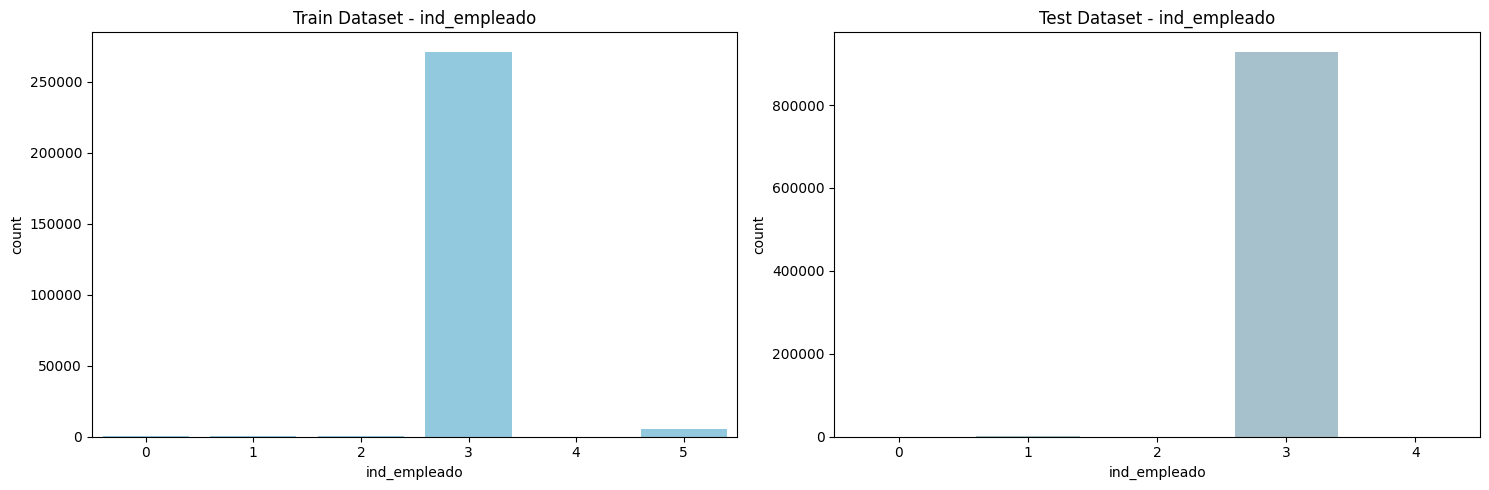

Plot for 'ind_empleado' column downloaded as 'ind_empleado_plot.png'


<Figure size 640x480 with 0 Axes>

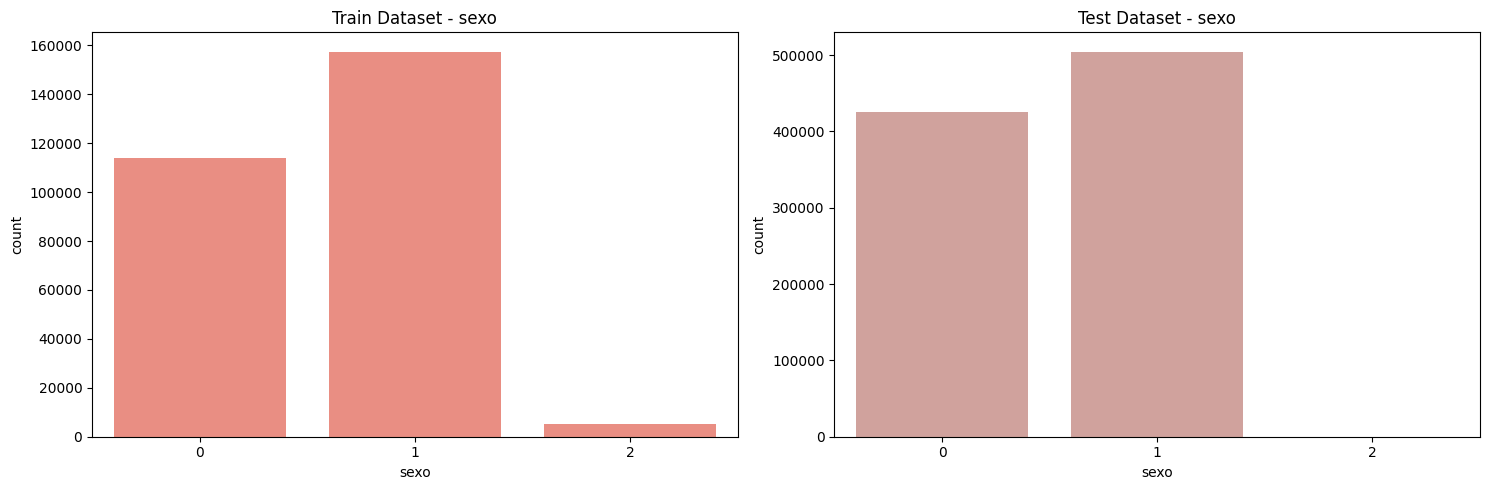

Plot for 'sexo' column downloaded as 'sexo_plot.png'


<Figure size 640x480 with 0 Axes>

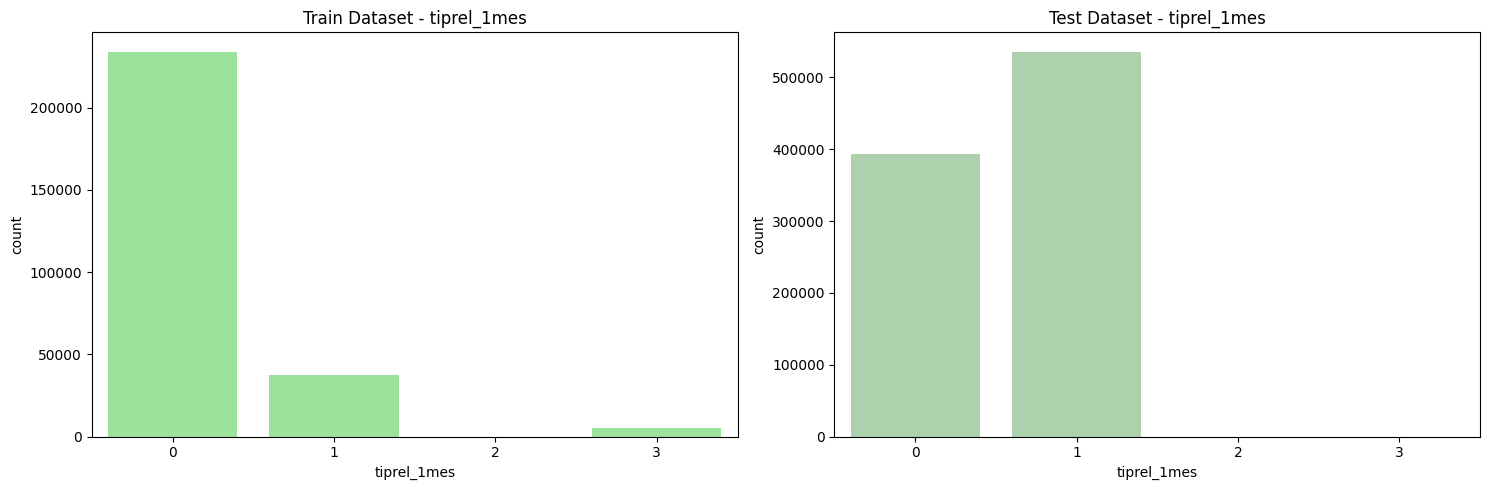

Plot for 'tiprel_1mes' column downloaded as 'tiprel_1mes_plot.png'


<Figure size 640x480 with 0 Axes>

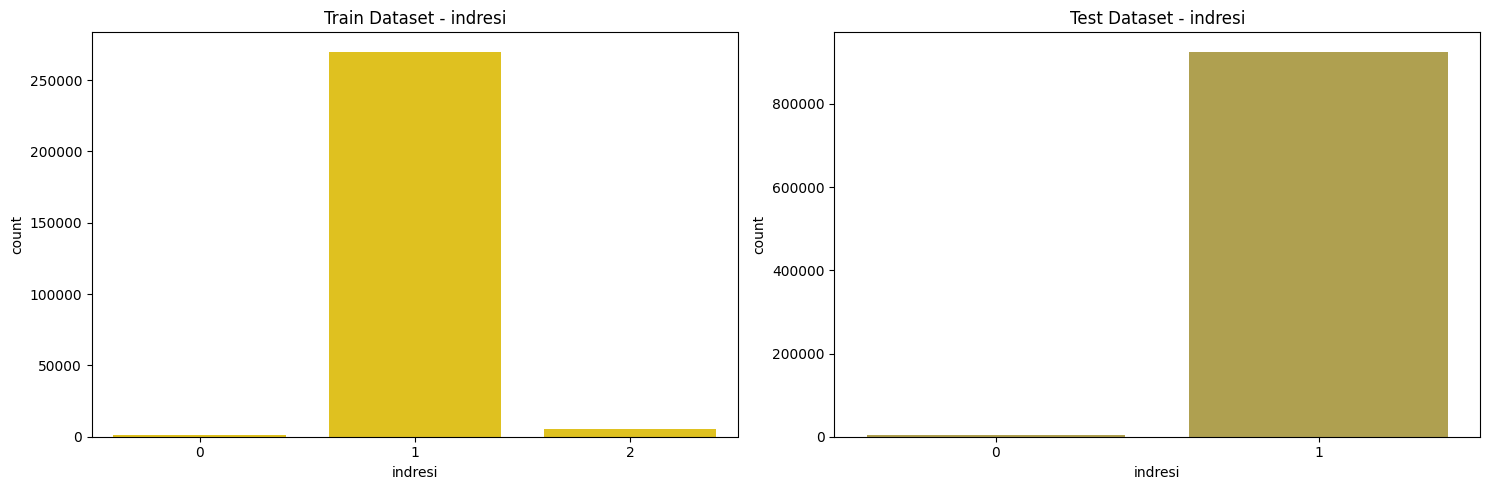

Plot for 'indresi' column downloaded as 'indresi_plot.png'


<Figure size 640x480 with 0 Axes>

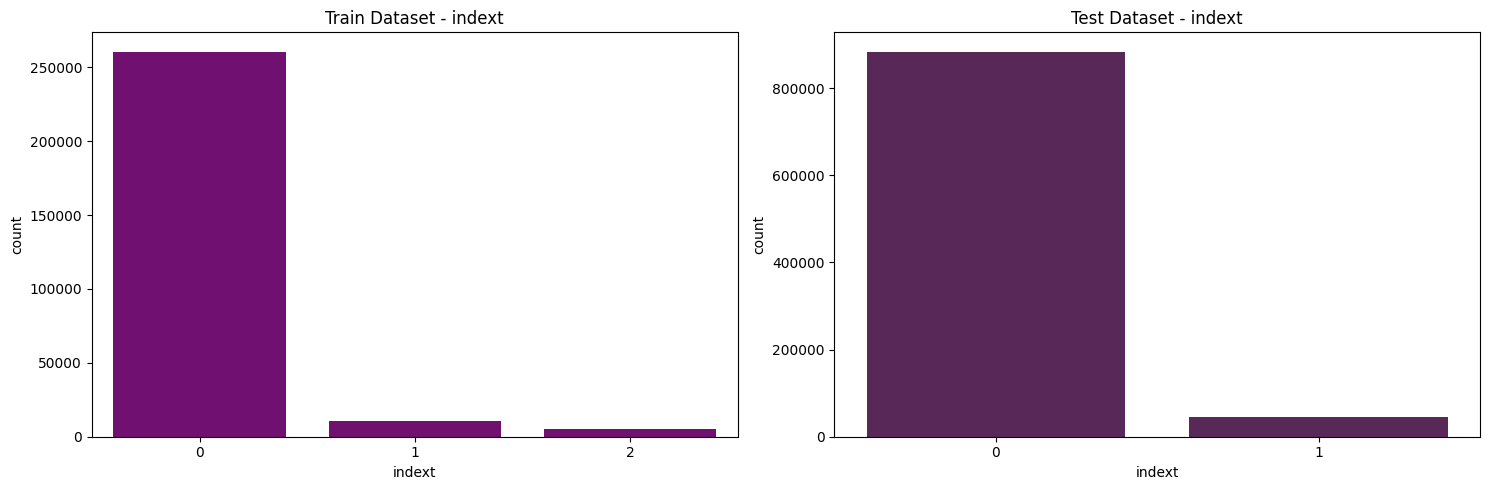

Plot for 'indext' column downloaded as 'indext_plot.png'


<Figure size 640x480 with 0 Axes>

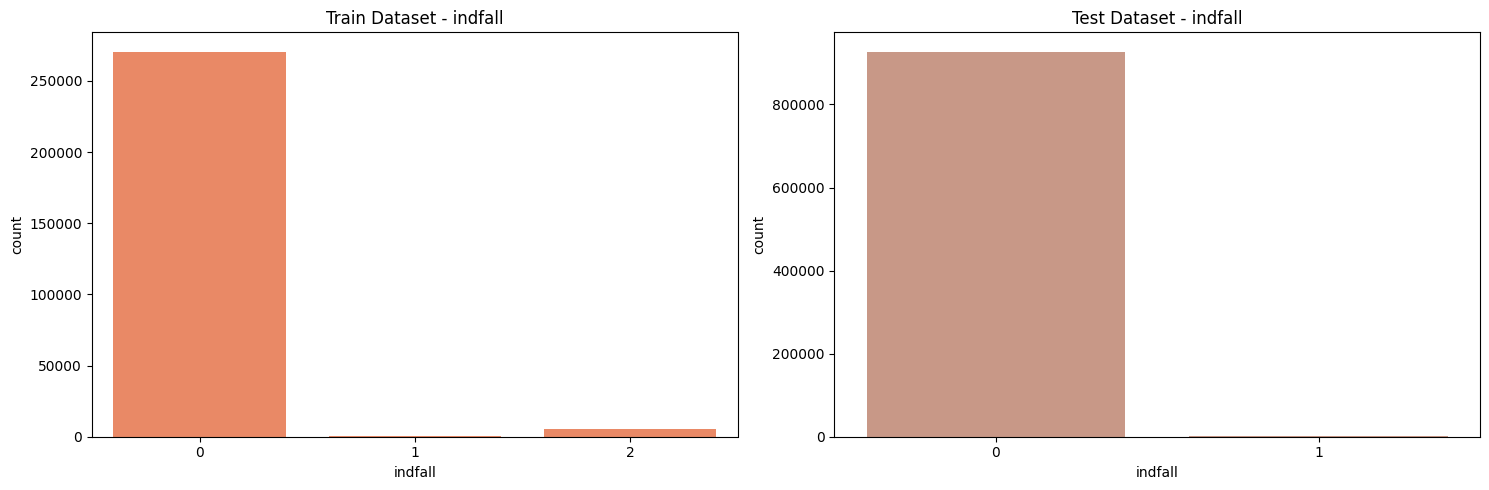

Plot for 'indfall' column downloaded as 'indfall_plot.png'


<Figure size 640x480 with 0 Axes>

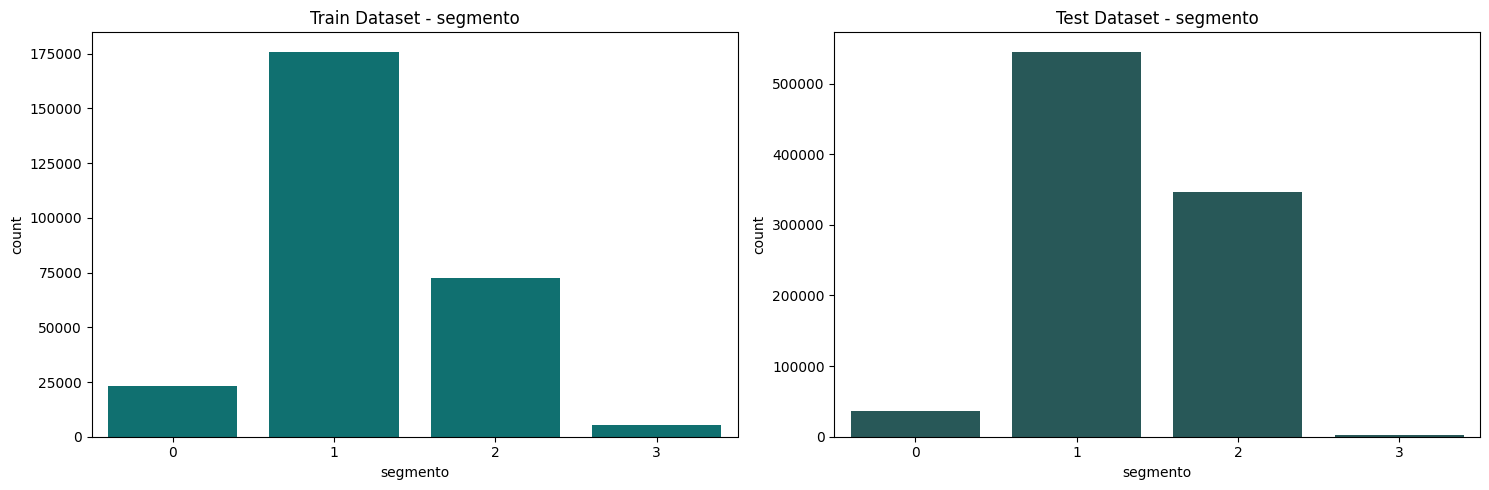

Plot for 'segmento' column downloaded as 'segmento_plot.png'


<Figure size 640x480 with 0 Axes>

In [107]:
import random

categorical_columns = ['ind_empleado', 'sexo', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'segmento']
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'purple', 'coral', 'teal']

column_colors = dict(zip(categorical_columns, colors))

# Plot each categorical column with a different color
for col, color in column_colors.items():
    # Create subplots for train and test datasets
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Train dataset
    train_color = color
    test_color = sns.desaturate(color, 0.5)  # Lighter shade for test dataset

    sns.countplot(data=new_df, x=col, ax=axs[0], color=train_color)
    axs[0].set_title(f'Train Dataset - {col}')

    # Test dataset
    sns.countplot(data=df_test1, x=col, ax=axs[1], color=test_color)
    axs[1].set_title(f'Test Dataset - {col}')

    plt.tight_layout()
    plt.show()

    # download it
    filename = f"{col}_plot.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Plot for '{col}' column downloaded as '{filename}'")

XGBoost

In [70]:
# train features
numerical_features_train = [new_num_feat]
categorical_features_train = [new_cat_feat]

target_variable_train = 'checked_services'

# test features
numerical_features_test = [n_features]
categorical_features_test = [c_features]

target_variable_test = 'checked_services'

# Split train and test sets into features and target variable
X_train = new_df.drop(columns=[target_variable_train])
y_train = new_df[target_variable_train]

X_test = df_test1.drop(columns=[target_variable_test])
y_test = df_test1[target_variable_test]

In [81]:
# Split train and test sets into features and target variable
X_train = new_df.drop(columns=[target_variable_train])
y_train = new_df[target_variable_train]

X_test = df_test1.drop(columns=[target_variable_test])
y_test = df_test1[target_variable_test]

# Drop date columns if they still exist in the DataFrame
date_columns = ['fecha_dato', 'fecha_alta']
new_df.drop(date_columns, axis=1, inplace=True, errors='ignore')


# Select only numeric and categorical columns in the train set
numeric_columns_train = X_train.select_dtypes(include=['int', 'float']).columns
categorical_columns_train = X_train.select_dtypes(include=['object', 'category']).columns

# Select only numeric and categorical columns in the test set
numeric_columns_test = X_test.select_dtypes(include=['int', 'float']).columns
categorical_columns_test = X_test.select_dtypes(include=['object', 'category']).columns

# Ensure that all remaining columns in the train set are numeric or categorical
numeric_df_train = X_train[numeric_columns_train]
categorical_df_train = X_train[categorical_columns_train]

# Ensure that all remaining columns in the test set are numeric or categorical
numeric_df_test = X_test[numeric_columns_test]
categorical_df_test = X_test[categorical_columns_test]

# If categorical columns still exist, you may need to encode them for both train and test sets
if not categorical_df_train.empty:
    # Perform encoding for categorical columns in the train set
    categorical_df_train = pd.get_dummies(categorical_df_train)

# If categorical columns still exist, you may need to encode them for the test set
if not categorical_df_test.empty:
    # Perform encoding for categorical columns in the test set
    categorical_df_test = pd.get_dummies(categorical_df_test)

# Concatenate numeric and encoded categorical columns for the train set
X_train_processed = pd.concat([numeric_df_train, categorical_df_train], axis=1)

# Concatenate numeric and encoded categorical columns for the test set
X_test_processed = pd.concat([numeric_df_test, categorical_df_test], axis=1)


In [72]:
print("Number of features used during training:", len(X_train.columns))
print("Number of columns in the test dataset:", X_test.shape[1])

Number of features used during training: 46
Number of columns in the test dataset: 22


In [73]:
print("Columns in X_train after preprocessing:", X_train.columns)
print("Columns in X_test:", X_test.columns)

Columns in X_train after preprocessing: Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes',
       'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall',
       'tipodom', 'cod_prov', 'nomprov', 'ind_actividad_cliente', 'renta',
       'segmento', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
       'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1'],
      dtype='object')
Columns in X_test: Index(['fecha_dato', 'ncodpers', 'ind_emplead

In [85]:
common_features = list(set(X_train.columns).intersection(X_test.columns))

X_train_filtered = X_train[common_features]
X_test_filtered = X_test[common_features]

print(X_train_filtered.head())
print(X_test_filtered.head())

    ind_nuevo  indfall  fecha_dato  fecha_alta          renta  canal_entrada  \
0         0.0        0  2015-01-28  2015-01-12   87218.100000            135   
4         0.0        0  2015-01-28  2012-08-10       5.000001            132   
7         0.0        0  2015-01-28  2012-08-10  113316.660000            132   
12        0.0        0  2015-01-28  2012-08-10  113538.810000            132   
13        0.0        0  2015-01-28  2012-08-10   61605.090000            132   

     age  indext  tiprel_1mes  antiguedad  ...  indrel_1mes  sexo  cod_prov  \
0   35.0       0            0         6.0  ...          1.0     0      29.0   
4   23.0       0            0        35.0  ...          1.0     1      50.0   
7   23.0       0            0        35.0  ...          1.0     0      50.0   
12  23.0       0            0        35.0  ...          1.0     0      49.0   
13  65.0       0            0        35.0  ...          1.0     0      50.0   

    indresi  ind_empleado  indrel  pais_resi

In [76]:
#import xgboost as xgb

#train = xgb.DMatrix(X_train_filtered, label=y_train)
#test = xgb.DMatrix(X_test_filtered, label=y_test)

In [78]:
import numpy as np

print("Unique values in y_train:", np.unique(y_train))
y_train = y_train.astype(int)

Unique values in y_train: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [79]:
# Subtract the minimum value from all the values in y_train to shift them to start from 0
y_train -= y_train.min()

# Print the unique values in y_train after the transformation
print("Unique values in y_train after transformation:", np.unique(y_train))


Unique values in y_train after transformation: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [93]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Preprocess the dataset to handle incompatible columns
# Drop columns with incompatible data types
X_train_subset = X_train_filtered.drop(['fecha_dato', 'fecha_alta', 'nomprov'], axis=1)

# Initialize XGBoost model
xgb_model = XGBRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50,
                                   scoring='neg_mean_squared_error', cv=3, n_jobs=-1, random_state=42)

# Perform the random search
random_search.fit(X_train_subset, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Initialize XGBoost model with the best hyperparameters
best_xgb_model = XGBRegressor(**best_params)

# Train the model on the filtered training dataset
best_xgb_model.fit(X_train_subset, y_train)

# Preprocess the test dataset similarly
X_test_subset = X_test_filtered.drop(['fecha_dato', 'fecha_alta', 'nomprov'], axis=1)

# Make predictions on the test dataset
predictions = best_xgb_model.predict(X_test_subset)


In [99]:
# Make predictions on the test set
predictions = best_xgb_model.predict(X_test_subset)

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared
r_squared = r2_score(y_test, predictions)
print("R-squared:", r_squared)

Mean Squared Error (MSE): 5.354332437543275
Mean Absolute Error (MAE): 2.1902204738622957
R-squared: -17.717282507935135


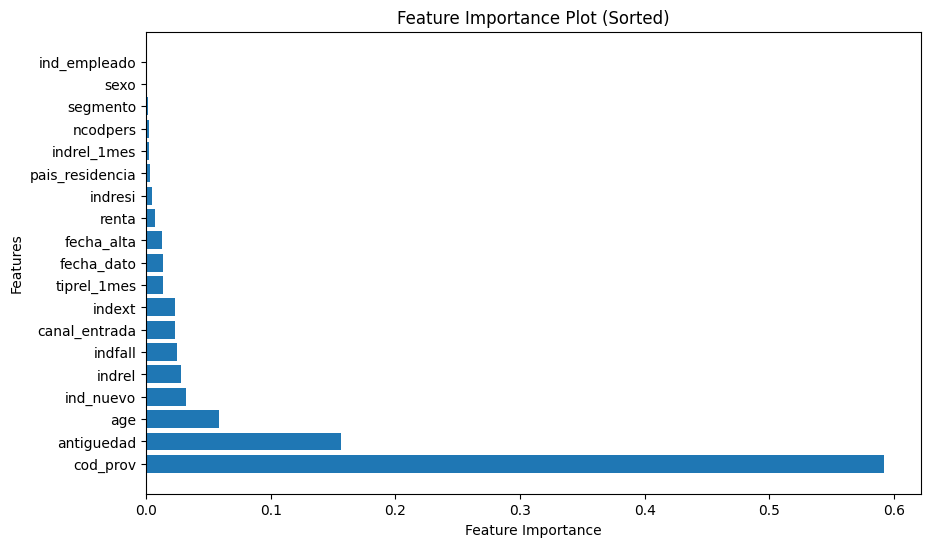

In [101]:
import numpy as np

# Get feature importance scores
feature_importance = best_xgb_model.feature_importances_

# Get feature names
feature_names = X_train_filtered.columns.tolist()

# Create a dictionary to store feature importance scores for each feature
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Get sorted feature names and importance scores
sorted_feature_names = [feature[0] for feature in sorted_feature_importance]
sorted_feature_scores = [feature[1] for feature in sorted_feature_importance]

# Plot sorted feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_scores)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot (Sorted)')
plt.show()


Most important:
3. `indrel_1mes`: Customer type at the beginning of the month. (1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)

`ind_empleado`: Employee index: A active, B ex employed, F filial, N not employee, P pasive


1. **`indrel_1mes` (Customer Type at the Beginning of the Month):**
   - This column represents the type of relationship the customer had with the bank at the start of the month.
   - For example:
     - A value of 1 indicates that the customer is a first/primary customer, which typically suggests a strong and active relationship with the bank.
     - A value of 2 indicates that the customer is a co-owner, implying a joint ownership or shared account.
     - Values like P (Potential), 3 (former primary), and 4 (former co-owner) represent potential customers or customers who had a different relationship status in the past.

2. **`ind_empleado` (Employee Index):**
   - This column denotes the employment status of the customer, where each letter code represents a different status.
   - For example:
     - A (Active) indicates that the customer is currently employed and likely to have a stable income.
     - B (Ex Employed) suggests that the customer was previously employed but is no longer working.
     - F (Filial) indicates that the customer is an employee of the bank's subsidiary.
     - N (Not Employee) denotes that the customer is not associated with the bank as an employee.
     - P (Passive) suggests that the customer is passive, possibly indicating retired or inactive status.


Submission

In [102]:
# Load the sample submission file
sample_submission_path = "/content/train/sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path)

# Check the length of the sample submission and the number of users in the dataset
print("Length of sample submission:", len(sample_submission))
print("Number of users in the dataset:", len(df_test))

# Ensure the lengths match by truncating or padding the predictions
if len(sample_submission) > len(df_test):
    # Truncate the sample submission to match the length of the test dataset
    sample_submission = sample_submission.iloc[:len(df_test)]
elif len(sample_submission) < len(df_test):
    # Pad the sample submission with empty predictions
    padding_length = len(df_test) - len(sample_submission)
    padding = pd.DataFrame({"ncodpers": [np.nan] * padding_length, "added_products": [""] * padding_length})
    sample_submission = pd.concat([sample_submission, padding], ignore_index=True)

# Save the corrected sample submission
sample_submission.to_csv("corrected_sample_submission.csv", index=False)


Length of sample submission: 929615
Number of users in the dataset: 929615


In [104]:
import pandas as pd
from google.colab import files

def extend_submission(predictions, output_filename):
    # Load the sample submission file
    sample_submission_path = "/content/train/sample_submission.csv"
    sample_submission = pd.read_csv(sample_submission_path)

    # Save the updated sample submission file
    output_path = f"{output_filename}.csv"
    sample_submission.to_csv(output_path, index=False)

    # Download the file
    files.download(output_path)

extend_submission(predictions, "my_submission(done)")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Citations:

@misc{santander-product-recommendation,
    author = {Meg Risdal, Mercedes Piedra, Wendy Kan},
    title = {Santander Product Recommendation},
    publisher = {Kaggle},
    year = {2016},
    url = {https://kaggle.com/competitions/santander-product-recommendation}
}




"BLACKBOXAI. (2023). BLACKBOXAI: A World-Class AI Assistant. https://www.blackboxai.com/"